In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.rcParams['figure.max_open_warning'] = 400
%matplotlib inline
%config InlineBackend.figure_format='retina'
#%config InlineBackend.figure_format = 'svg'

## vague gravitationnelle

In [7]:
name = 'waves'
import os
import numpy as np
import MotionClouds as mc
mc.N_X, mc.N_Y, mc.N_frame = 128, 32, 512
fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
print (mc.figpath)
vext = '.webm'
theta, B_theta, B_wave = 0., np.pi/16., .1
alpha, sf_0, B_sf, B_V = 2., .25, .3, 2.
seed = 1234565
V_X, V_Y, g = .5, 0., .1
loggabor=True
def envelope_gravity(fx, fy, ft, B_wave, g=.1):
    """
     Gravitational envelope:
     selects the plane corresponding to the speed (V_X, V_Y) with some thickness B_V

    """
    k = fx*V_X+fy*V_Y
    env = np.exp(-.5*(((ft/.5)**2-g*np.sqrt(((k/.5)**2)))**2/(B_wave*mc.frequency_radius(fx, fy, ft, ft_0=np.inf))**2))
    env *= (ft*k) < 0
    return env

def envelope_gabor_wave(fx, fy, ft, B_wave, V_X=mc.V_X, V_Y=mc.V_Y,
                        B_V=mc.B_V, B_v=1., sf_0=mc.sf_0, B_sf=mc.B_sf, loggabor=mc.loggabor,
                        theta=mc.theta, B_theta=mc.B_theta, alpha=mc.alpha):
    """
    Returns the Motion Cloud kernel

    """
    envelope = mc.envelope_gabor(fx, fy, ft, V_X=V_X, V_Y=V_Y,
                                 B_V=B_V, sf_0=sf_0, B_sf=B_sf, loggabor=loggabor,
                                 theta=theta, B_theta=B_theta, alpha=alpha)
    envelope *= envelope_gravity(fx, fy, ft, B_wave=B_wave)
    return envelope

B_v_low, B_v_high = .025, .1

name_ = name + '_low'
mc_dense = envelope_gabor_wave(fx, fy, ft, V_X=1., V_Y=0., B_wave=B_v_low, B_V=B_V, theta=theta, B_theta=B_theta, sf_0=sf_0, B_sf=B_sf, alpha=alpha)
mc.figures(mc_dense, name_, vext=vext, seed=seed)
mc.in_show_video(name_)


../files/


Saving the corrresponding cloud as a ``nd.array``:

In [8]:
vague_dense = mc.rectif(mc.random_cloud(mc_dense))
print(vague_dense.shape)

(128, 32, 512)


In [9]:
theta, B_theta, B_wave = 0., np.pi/8., .1
alpha, sf_0, B_sf, B_V = 1., .1, .3, 2.
seed = 1234565
V_X, V_Y, g = .5, 0., 2
loggabor=True

def envelope_gravity2(fx, fy, ft, V_X, V_Y, B_wave, g):
    k = fx*V_X+fy*V_Y
    env = np.exp(-.5*(((ft/.5)**2-g*np.sqrt(((k/.5)**2)))**2/(B_wave*mc.frequency_radius(fx, fy, ft, ft_0=np.inf))**2))
    env *= (ft*k) < 0
    return env

def envelope_gabor_wave2(fx, fy, ft, V_X, V_Y, B_V, B_wave, sf_0, B_sf, theta, B_theta, alpha, g):
    envelope = mc.envelope_gabor(fx, fy, ft, V_X, V_Y, B_V, sf_0, B_sf, loggabor, theta, B_theta, alpha)
    envelope *= envelope_gravity2(fx, fy, ft, V_X, V_Y, B_wave, g)
    return envelope

mc_wave = envelope_gabor_wave2(fx, fy, ft, V_X, V_Y, B_V, B_wave, sf_0, B_sf, theta, B_theta, alpha, g)
mc.figures(mc_wave, 'waves_impulse', seed=seed, impulse=True)
mc.in_show_video('waves_impulse')
mc.figures(mc_wave, 'waves_mc', seed=seed)
mc.in_show_video('waves_mc')

In [10]:
vague_solo = mc.rectif(mc.random_cloud(mc_wave, seed=seed, impulse=True))
print(vague_solo.shape)

(128, 32, 512)


## transforme la vague 2D sur les lames

In [13]:
def vague_animate(z, x_offset=0, y_offset=0, N_lame = 25, t_offset=0, N_steps = 256):
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from IPython.display import HTML

    fig, ax = plt.subplots(figsize=(15, 3))

    x = np.arange(0, N_lame)        # x-array

    def vague(i):
        return z[x_offset:(x_offset+N_lame), y_offset, t_offset+i]

    def animate(i):
        line.set_ydata(vague(i))  # update the data
        return line,

    #Init only required for blitting to give a clean slate.
    def init():
        line.set_ydata(np.ma.array(x, mask=True))
        return line,

    line,  = ax.plot(x, vague(0))
    ax.set_xlim([0, N_lame-1])
    ax.set_ylim([0, 1])

    anim = animation.FuncAnimation(fig, animate, np.arange(1, N_steps), init_func=init,
        interval=25, blit=True)

    return HTML(anim.to_html5_video())
    

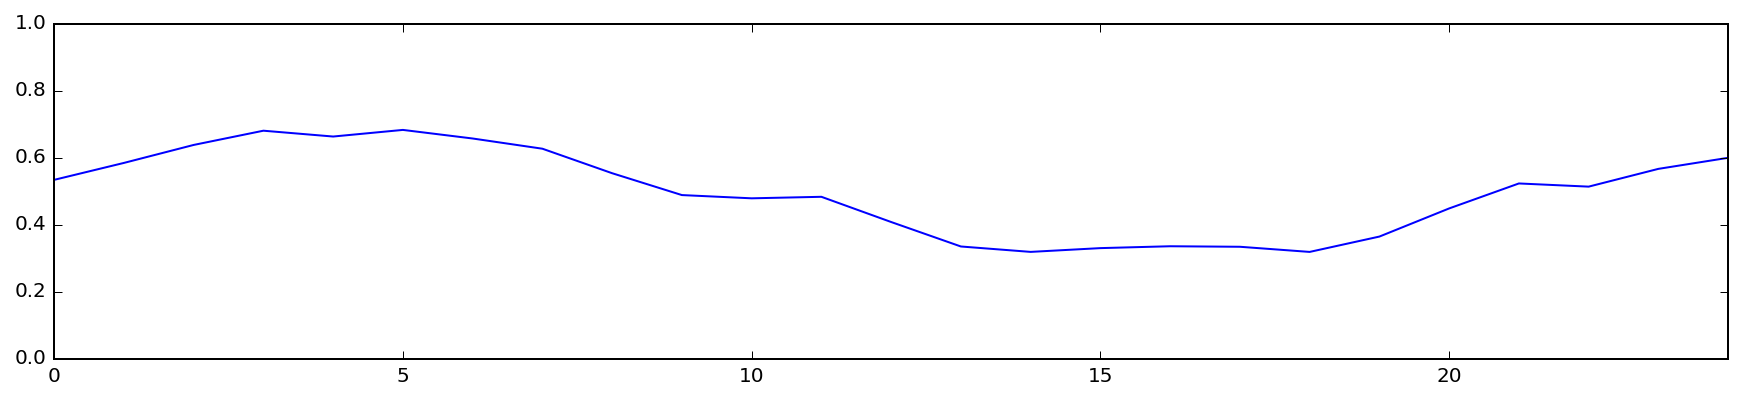

In [14]:
vague_animate(vague_dense)

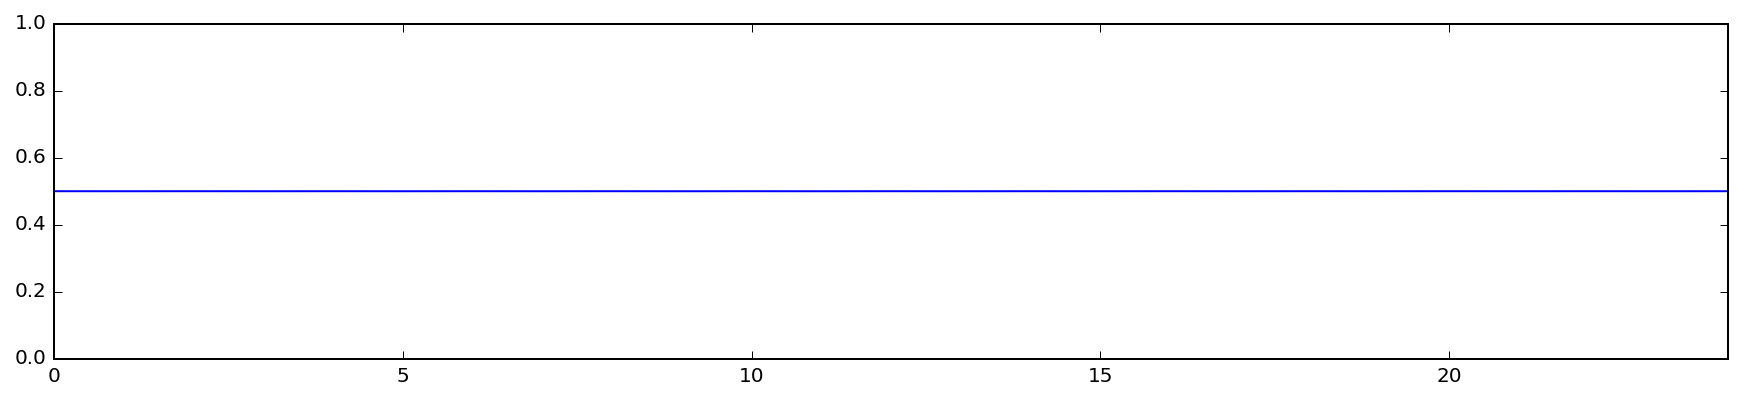

In [16]:
vague_animate(vague_solo, x_offset=vague_solo.shape[0]//2-25//2, y_offset=vague_solo.shape[1]//2, t_offset=0, N_steps = vague_solo.shape[-1])

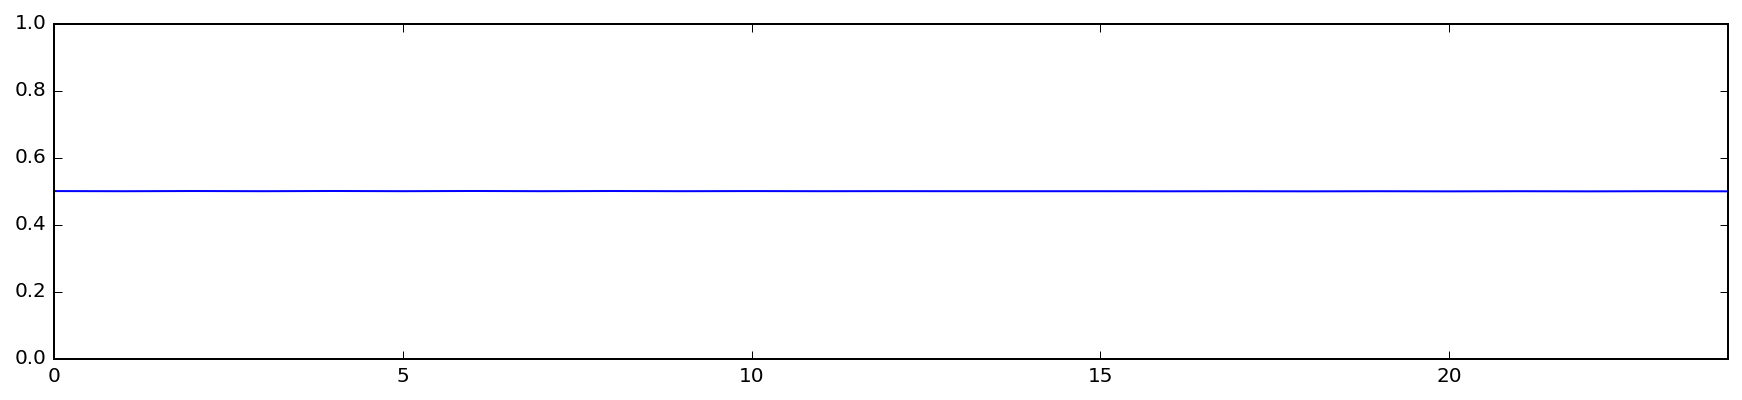

In [17]:
vague_animate(vague_solo, x_offset=vague_solo.shape[0]//2-25//2, y_offset=vague_solo.shape[1]//2, t_offset=vague_solo.shape[-1]//4, N_steps=vague_solo.shape[-1]//2)

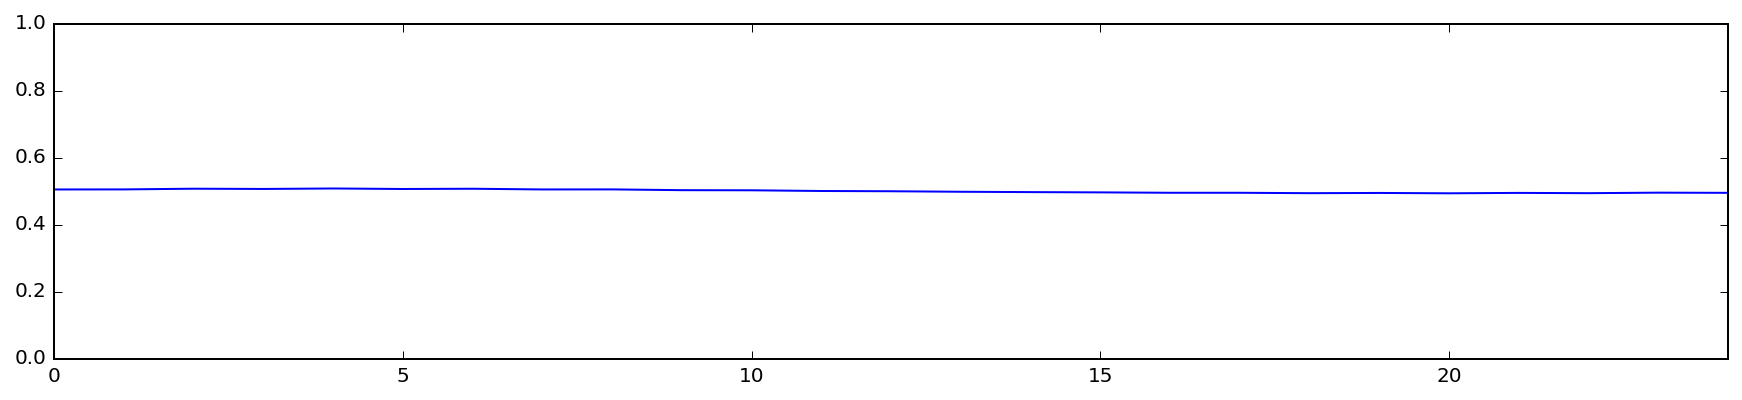

In [18]:
vague_animate(vague_solo, x_offset=vague_solo.shape[0]//2-25//2, y_offset=vague_solo.shape[1]//2, 
              t_offset=vague_solo.shape[-1]*3//8, N_steps=vague_solo.shape[-1]//4)

## Saving as a scenario

In [94]:
%%writefile ../scenario_line_vague.py
#!/usr/bin/env python
# -*- coding: utf8 -*-

import elasticite as el
import numpy as np

def make_vague():
    name = 'waves'
    import os
    import numpy as np
    import MotionClouds as mc
    mc.N_X, mc.N_Y, mc.N_frame = 128, 32, 256

    fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
    theta, B_theta, B_wave = 0., np.pi/16., .1
    alpha, sf_0, B_sf, B_V = 2., .25, .3, 2.
    seed = 1234565
    V_X, V_Y, g = .5, 0., .1
    loggabor=True

    def envelope_gravity(fx, fy, ft, B_wave, g=.1):
        """
         Gravitational envelope:
         selects the plane corresponding to the speed (V_X, V_Y) with some thickness B_V

        """
        k = fx*V_X+fy*V_Y
        env = np.exp(-.5*(((ft/.5)**2-g*np.sqrt(((k/.5)**2)))**2/(B_wave*mc.frequency_radius(fx, fy, ft, ft_0=np.inf))**2))
        env *= (ft*k) < 0
        return env

    def envelope_gabor_wave(fx, fy, ft, B_wave, V_X=mc.V_X, V_Y=mc.V_Y,
                            B_V=mc.B_V, B_v=1., sf_0=mc.sf_0, B_sf=mc.B_sf, loggabor=mc.loggabor,
                            theta=mc.theta, B_theta=mc.B_theta, alpha=mc.alpha):
        """
        Returns the Motion Cloud kernel

        """
        envelope = mc.envelope_gabor(fx, fy, ft, V_X=V_X, V_Y=V_Y,
                                     B_V=B_V, sf_0=sf_0, B_sf=B_sf, loggabor=loggabor,
                                     theta=theta, B_theta=B_theta, alpha=alpha)
        envelope *= envelope_gravity(fx, fy, ft, B_wave=B_wave)
        return envelope

    B_v_low, B_v_high = .025, .1

    mc_vague = envelope_gabor_wave(fx, fy, ft, V_X=1., V_Y=0., B_wave=B_v_low, B_V=B_V, theta=theta, B_theta=B_theta, sf_0=sf_0, B_sf=B_sf, alpha=alpha)
    vague_dense = mc.rectif(mc.random_cloud(mc_vague))
    vague_solo = mc.rectif(mc.random_cloud(mc_vague, seed=seed, impulse=True))
    return vague_dense, vague_solo

class EdgeGrid(el.EdgeGrid):
    def __init__(self, vague, x_offset=0, y_offset=0, t_offset=0, N_steps = 256, **kwargs):
        #super(el.EdgeGrid.__init__(self))
        #super(el.EdgeGrid, self).__init__(**kwargs)
        el.EdgeGrid.__init__(self, **kwargs)
        #print (self.verb, kwargs)
        self.vague = vague
        self.x_offset = x_offset
        self.y_offset = y_offset
        self.t_offset = t_offset
        self.N_steps = N_steps
        #print(self.x_offset, self.y_offset, self.t_offset)
        #print(self.z.shape)
        
        
    def update(self):
        if self.structure: N_lame = self.N_lame-self.struct_N
        else: N_lame = self.N_lame
        damp_min = 0.01
        damp_tau = .5
        damp = lambda t: damp_min + (1.-damp_min)*np.exp(-np.abs(np.mod(t+self.period/2, self.period)-self.period/2)/damp_tau)

        i = np.mod(np.int(self.t/self.period * self.N_steps), self.vague.shape[2])
        surface = self.vague[self.x_offset:(self.x_offset+N_lame), self.y_offset, self.t_offset+i]
        dsurface = np.gradient(surface)
        dsurface /= np.abs(dsurface).max()
        
        self.lames[2, :N_lame] = np.tan(surface)
        
if __name__ == "__main__":
    import sys
    if len(sys.argv)>1: mode = sys.argv[1]
    else: mode = 'both'
        
    vague_dense, vague_solo = make_vague()

    e = EdgeGrid(N_lame=25, grid_type='line', mode=mode,
                 verb=True, period=20., # filename='mat/line_vague_dense.npy', 
                 vague = vague_dense,
                 x_offset=0, y_offset=0, t_offset=0, N_steps=512)

    # running the code
    el.main(e)

    e = EdgeGrid(N_lame=25, grid_type='line', mode=mode,
                 verb=True, period=20., #filename='mat/line_vague_solo.npy', 
                 vague = vague_solo,
                 x_offset=vague_solo.shape[0]//2-25//2, y_offset=vague_solo.shape[1]//2, 
                 t_offset=vague_solo.shape[-1]*3//8, N_steps=vague_solo.shape[-1]//4)

    # running the code
    el.main(e)

Overwriting ../scenario_line_vague.py


## git


In [ ]:
! git add 2015-11-26*
!git s

In [ ]:
!git commit -am' scenario vague '

In [ ]:
! git push
